In [1]:
# Libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from helperfunctions import kfold_cross_validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from IPython.core.interactiveshell import InteractiveShell

# Notebook Settings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Variables
crop_seasons = list(range(1993,2017))
months_of_crop_season = list(range(4,12))
homogeneous_groups = list(range(1,5))
models = ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]

### 1. Read Data

In [2]:
kfold_cv_dataset = pd.read_csv("kfold_cv_dataset.csv")

## 2. Simulate wheat yield

In [47]:
def perform_simulations_and_compute_metrics(df):
    rmse_scores = pd.DataFrame(0, index=models, columns=months_of_crop_season)
    r2_scores = pd.DataFrame(0, index=models, columns=months_of_crop_season)
    simulations = []
    for month in months_of_crop_season:
        for model in models:
            res = kfold_cross_validation(df, model=model, init=month, no_of_features=8)
            res = res.assign(model=model, init_month=month)
            simulations.append(res)
            # rmse
            rmse_score = 100 * mse(res["yield"], res["predicted"], squared=False)/(res["yield"].mean())
            rmse_scores.loc[model, month] = np.round(rmse_score, 2)
            # coefficient of determination
            r2_score = r2(res["yield"], res["predicted"])
            r2_scores.loc[model, month] = np.round(r2_score, 2)
    
    simulations = pd.concat(simulations, ignore_index=False, axis=0)    
    return (simulations, rmse_scores, r2_scores)

In [48]:
simulations, rmse_scores, r2_scores = perform_simulations_and_compute_metrics(kfold_cv_dataset)

In [49]:
simulations.sample(2)
rmse_scores.head(5)
r2_scores.head(5)

,year,predicted,yield,model,init_month
11,2004,2753.335053,2692.237029,UKMO,10
11,2004,2828.210255,2692.237029,MME,10


,4,5,6,7,8,9,10,11
ECMWF,11.56,11.90,11.23,11.44,10.58,9.49,7.88,6.01
NCEP,14.34,14.88,14.70,12.74,11.84,10.45,9.26,6.01
UKMO,12.28,12.71,10.79,12.13,11.07,10.61,7.64,6.01
MME,12.12,12.47,11.76,11.62,10.47,9.86,7.90,6.01
CLIMATE,11.75,11.75,11.75,11.75,11.75,10.27,9.13,6.01


,4,5,6,7,8,9,10,11
ECMWF,-0.05,-0.12,0.01,-0.03,0.12,0.29,0.51,0.72
NCEP,-0.62,-0.75,-0.70,-0.28,-0.10,0.14,0.32,0.72
UKMO,-0.19,-0.27,0.08,-0.16,0.03,0.11,0.54,0.72
MME,-0.16,-0.23,-0.09,-0.06,0.14,0.23,0.51,0.72
CLIMATE,-0.09,-0.09,-0.09,-0.09,-0.09,0.17,0.34,0.72


In [34]:
simulations.loc[(simulations["init_month"] == 11) & (simulations["model"].isin(["WS", "MME"])) & (simulations["year"] == 1993)]

,year,predicted,yield,model,init_month
1080,1993,2486.781526,2687.363636,MME,11
1128,1993,2486.781526,2687.363636,WS,11


### 3. Visualizations
#### 3.1 RMSE and R2 development

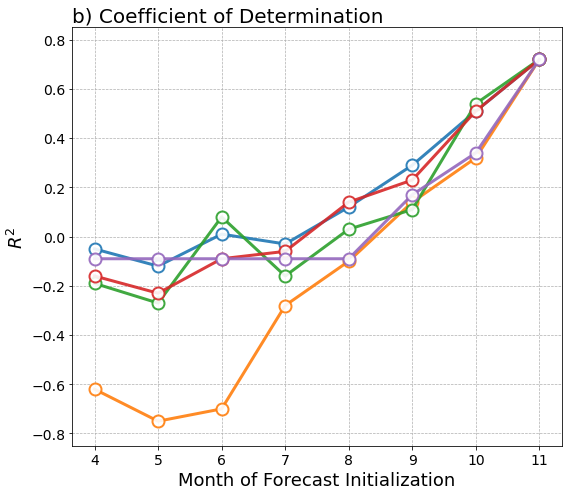

In [117]:
ax = r2_scores.loc[r2_scores.index != "WS"].transpose().plot(figsize=(8,7), 
                                                                 marker='o', 
                                                                 ms=12, 
                                                                 lw=3, 
                                                                 linestyle='-', 
                                                                 alpha=.9, 
                                                                 markerfacecolor='white',
                                                                 markeredgewidth=2.0, 
                                                                 legend=False)
ax.grid('on', which='both', axis='y', linestyle='--', linewidth=.7)
ax.grid('on', which='both', axis='x', linestyle='--', linewidth=.7)
ax.set_xlabel('Month of Forecast Initialization', fontsize=18)
ax.set_ylabel(r'$R^{2}$', fontsize=18)
#ax.set_ylabel('RRMSE [%]', fontsize=18)
#ax.set_title('a) Relative Root-Mean-Square Error', loc="left", fontsize=20)
ax.set_title('b) Coefficient of Determination', loc="left", fontsize=20)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#ax.legend(fontsize=15)
#ax.set_ylim(5.5, 16.5)
ax.set_ylim(-0.85, 0.85)
plt.tight_layout()
#plt.savefig("images/r2score_development.png", dpi=1000)
plt.show();

#### 3.2 Graphical Analysis of residuals

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Yield [t/ha]')

Text(0.0, 1.0, 'a) August')

(1.9, 3.3)

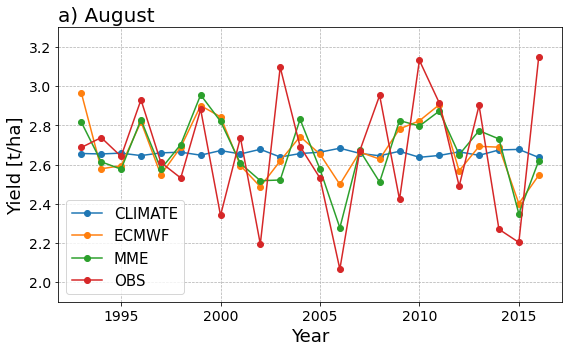

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Yield [t/ha]')

Text(0.0, 1.0, 'b) September')

(1.9, 3.3)

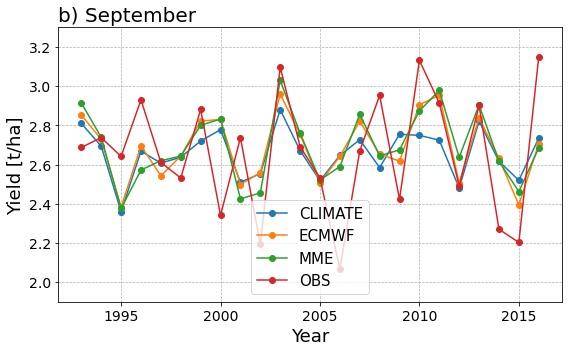

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Yield [t/ha]')

Text(0.0, 1.0, 'c) October')

(1.9, 3.3)

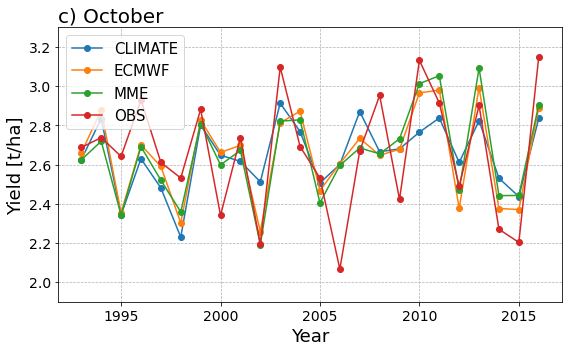

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Yield [t/ha]')

Text(0.0, 1.0, 'd) November')

(1.9, 3.3)

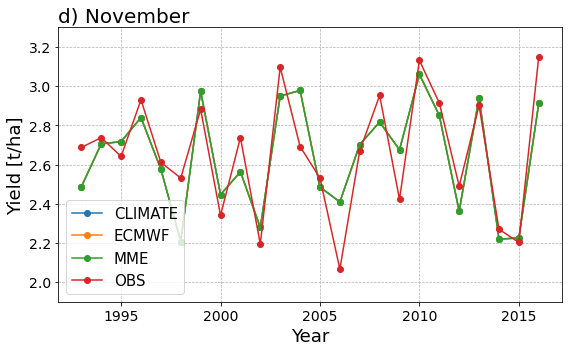

In [107]:
titles = dict(zip([8, 9, 10, 11], ["a) August", "b) September", "c) October", "d) November"]))
for im in [8, 9, 10, 11]:
    #results = pd.DataFrame(0, index=models + ["OBS"], columns=list(range(1993,2017)))
    plot_sims = simulations.loc[(simulations["init_month"] == im) & (simulations["model"].isin(["MME", "ECMWF", "CLIMATE"]))].pivot(index="year", columns="model", values="predicted")
    plot_obs = simulations.iloc[:24, [0,2,3]].assign(model="OBS").pivot(index="year", columns="model", values="yield")
    plot_all = plot_sims.merge(plot_obs, on="year").apply(lambda x: x/1000)
    
    ax = plot_all.plot(figsize=(8,5), marker='o')
    ax.grid('on', which='both', axis='y', linestyle='--', linewidth=.7)
    ax.grid('on', which='both', axis='x', linestyle='--', linewidth=.7)
    ax.set_xlabel("Year", fontsize=18)
    ax.set_ylabel("Yield [t/ha]", fontsize=18)
    ax.set_title(titles[im], loc="left", fontsize=20)
    ax.set_ylim(1.9, 3.3)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.legend(fontsize=15)
    name = str(titles[im])
    plt.tight_layout()
    #plt.savefig("images/" + name + ".svg")
    plt.show();

#### 3.3 Pearson R of Climate Features

In [168]:
results_tmean = pd.DataFrame(0, index=["CLIMATE", "ECMWF", "UKMO", "NCEP", "MME"], columns=list(range(7,11)))
results_rain= pd.DataFrame(0, index=["CLIMATE", "ECMWF", "UKMO", "NCEP", "MME"], columns=list(range(7,11)))
for m in ["CLIMATE", "ECMWF", "UKMO", "NCEP", "MME"]:
    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([7])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if ("Tmean" in c) or (c in ["model", "init_month"])]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if ("Tmean" in c) or (c in ["model", "init_month"])]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_tmean.loc[m, 7] = sum(abs(model - observation))/model.shape[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([8])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"]))]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"]))]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_tmean.loc[m, 8] = sum(abs(model - observation))/model.shape[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([9])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"])) & ("Aug" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"])) & ("Aug" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_tmean.loc[m, 9] = sum(abs(model - observation))/model.shape[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([10])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"])) & ("Sep" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"])) & ("Sep" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_tmean.loc[m, 10] = sum(abs(model - observation))/model.shape[0] 
    
for m in ["CLIMATE", "ECMWF", "UKMO", "NCEP", "MME"]:
    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([7])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if ("Rain" in c) or (c in ["model", "init_month"])]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if ("Rain" in c) or (c in ["model", "init_month"])]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_rain.loc[m, 7] = sum(abs(model - observation))/model.shape[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([8])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"]))]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"]))]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_rain.loc[m, 8] = sum(abs(model - observation))/model.shape[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([9])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"])) & ("Aug" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"])) & ("Aug" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_rain.loc[m, 9] = sum(abs(model - observation))/model.shape[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([10])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"])) & ("Sep" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"])) & ("Sep" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_rain.loc[m, 10] = sum(abs(model - observation))/model.shape[0] 


In [170]:
results_tmean = pd.DataFrame(0, index=["CLIMATE", "ECMWF", "UKMO", "NCEP", "MME"], columns=list(range(7,11)))
results_rain= pd.DataFrame(0, index=["CLIMATE", "ECMWF", "UKMO", "NCEP", "MME"], columns=list(range(7,11)))
for m in ["CLIMATE", "ECMWF", "UKMO", "NCEP", "MME"]:
    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([7])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if ("Tmean" in c) or (c in ["model", "init_month"])]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if ("Tmean" in c) or (c in ["model", "init_month"])]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_tmean.loc[m, 7] = pearsonr(model, observation)[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([8])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"]))]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"]))]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_tmean.loc[m, 8] = pearsonr(model, observation)[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([9])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"])) & ("Aug" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"])) & ("Aug" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_tmean.loc[m, 9] = pearsonr(model, observation)[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([10])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"])) & ("Sep" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Tmean" in c) or (c in ["model", "init_month"])) & ("Sep" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_tmean.loc[m, 10] = pearsonr(model, observation)[0] 
    
for m in ["CLIMATE", "ECMWF", "UKMO", "NCEP", "MME"]:
    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([7])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if ("Rain" in c) or (c in ["model", "init_month"])]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if ("Rain" in c) or (c in ["model", "init_month"])]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_rain.loc[m, 7] = pearsonr(model, observation)[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([8])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"]))]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"]))]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_rain.loc[m, 8] = pearsonr(model, observation)[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([9])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"])) & ("Aug" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"])) & ("Aug" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_rain.loc[m, 9] = pearsonr(model, observation)[0] 

    model = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([10])) & (kfold_cv_dataset["model"] == m), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"])) & ("Sep" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    observation = kfold_cv_dataset.loc[(kfold_cv_dataset["init_month"].isin([11])) & (kfold_cv_dataset["model"] == "WS"), [c for c in kfold_cv_dataset.columns if (("Rain" in c) or (c in ["model", "init_month"])) & ("Sep" not in c)]].reset_index(drop=True).set_index(["model", "init_month"]).values.reshape(1,-1).flatten()
    results_rain.loc[m, 10] = pearsonr(model, observation)[0] 


In [172]:
results_rain.round(2)
results_tmean.round(2)

,7,8,9,10
CLIMATE,0.46,0.46,0.26,0.78
ECMWF,0.51,0.59,0.54,0.82
UKMO,0.42,0.54,0.41,0.78
NCEP,0.36,0.50,0.42,0.83
MME,0.47,0.58,0.49,0.83


,7,8,9,10
CLIMATE,0.89,0.89,0.88,0.96
ECMWF,0.89,0.91,0.91,0.97
UKMO,0.87,0.87,0.87,0.97
NCEP,0.81,0.85,0.87,0.96
MME,0.87,0.89,0.90,0.97


In [169]:
results_rain
results_tmean

,7,8,9,10
CLIMATE,71.421498,71.421498,75.505254,37.508152
ECMWF,68.777554,63.407962,65.033792,34.744499
UKMO,82.051721,72.628731,74.661343,38.942888
NCEP,75.731704,68.035923,74.041177,33.855061
MME,72.723931,64.407874,66.911936,33.394144


,7,8,9,10
CLIMATE,1.005656,1.005656,1.048188,0.474403
ECMWF,1.011432,0.921081,0.917890,0.368247
UKMO,1.086265,1.071236,1.067302,0.432308
NCEP,1.304075,1.170736,1.061853,0.478418
MME,1.078469,0.981564,0.950362,0.391410
